# US Adult Income

## Purpose of the project

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
...
</div>

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

from fairlearn.metrics import demographic_parity_difference, MetricFrame, mean_prediction, equal_opportunity_difference

import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils

import multiprocessing

c:\Users\ol200\AppData\Local\Programs\Python\Python311\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\ol200\AppData\Local\Programs\Python\Python311\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrat

## Table of Contents

- [1. Dataset](#dataset) 
    - [a. Description](#description) 
    - [b. Data cleaning](#data-cleaning)
- [2. Bias](#bias)
    - [a. Sensitive features](#sensitive-features) 
    - [b. Detailed sensitive groups](#detailed-sensitive-groups)
    - [c. Preprocess](#preprocess) 
    - [d. Define MLP](#define-mlp) 
    - [e. Preparing sets](#preparing-sets) 
    - [f. Training](#training)
    - [g. Classification performance](#classification-performance)
    - [h. Fairness quantification with fairlearn](#fairness-quantification-with-fairlearn)
    - [i. Improving fairness by a pre processing fairness algorithm](#improving-fairness-by-a-pre-processing-fairness-algorithm)


## Dataset

### Description

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The US Adult Income dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/johnolafenwa/us-census-data), was originally extracted by Barry Becker from the 1994 US Census Database. It contains anonymous data about various social and economic factors, including occupation, age, native country, race, capital gain, capital loss, education, work class, and more.

Each entry in the dataset is labeled based on income, categorizing individuals as earning either ">50K" or "<=50K" annually. This classification allows for the analysis of how different social factors correlate with income levels.

The dataset is divided into two CSV files:
* `adult-training.txt`: Contains data used for training models.
* `adult-test.txt`: Contains data used for testing models.

This dataset is commonly utilized for machine learning tasks focused on income prediction and social factor analysis.
</div>

### Data cleaning

##### Read data

In [2]:
# Define path to data files
train_file = "data/adult-training.csv"
test_file = "data/adult-test.csv"

In [3]:
# Define columns
COLUMNS = ["age", "workclass", "fnlwgt", "education","education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]

In [4]:
# Read data into df
df_train = pd.read_csv(train_file, names = COLUMNS, skipinitialspace = True, engine= "python")
df_test = pd.read_csv(test_file, names = COLUMNS, skipinitialspace = True, skiprows=1, engine = "python")

##### Investigate the data

In [ ]:
# Set size
print("Train set :", df_train.shape)
print("Test set :", df_test.shape)

Train set : (32561, 15)
Test set : (16281, 15)


In [6]:
# Check if there are any missing (NaN) values in the DataFrame
print("Any missing (NaN) values in the train set ? :", df_train.isnull().values.any())
print("Any missing (NaN) values in the test set ? :", df_test.isnull().values.any())

Any missing (NaN) values in the train set ? : False
Any missing (NaN) values in the test set ? : False


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
&rarr; We don't need to remove NaN values
</div>

In [7]:
# Display the first few rows of the training data to verify
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Distribution of income values :
</div>

In [8]:
#  in train set
df_train.income_bracket.value_counts(normalize=True)

income_bracket
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

In [9]:
# Distribution of income values in test set
df_test.income_bracket.value_counts(normalize=True)

income_bracket
<=50K.    0.763774
>50K.     0.236226
Name: proportion, dtype: float64

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Statistics on train set :
</div>

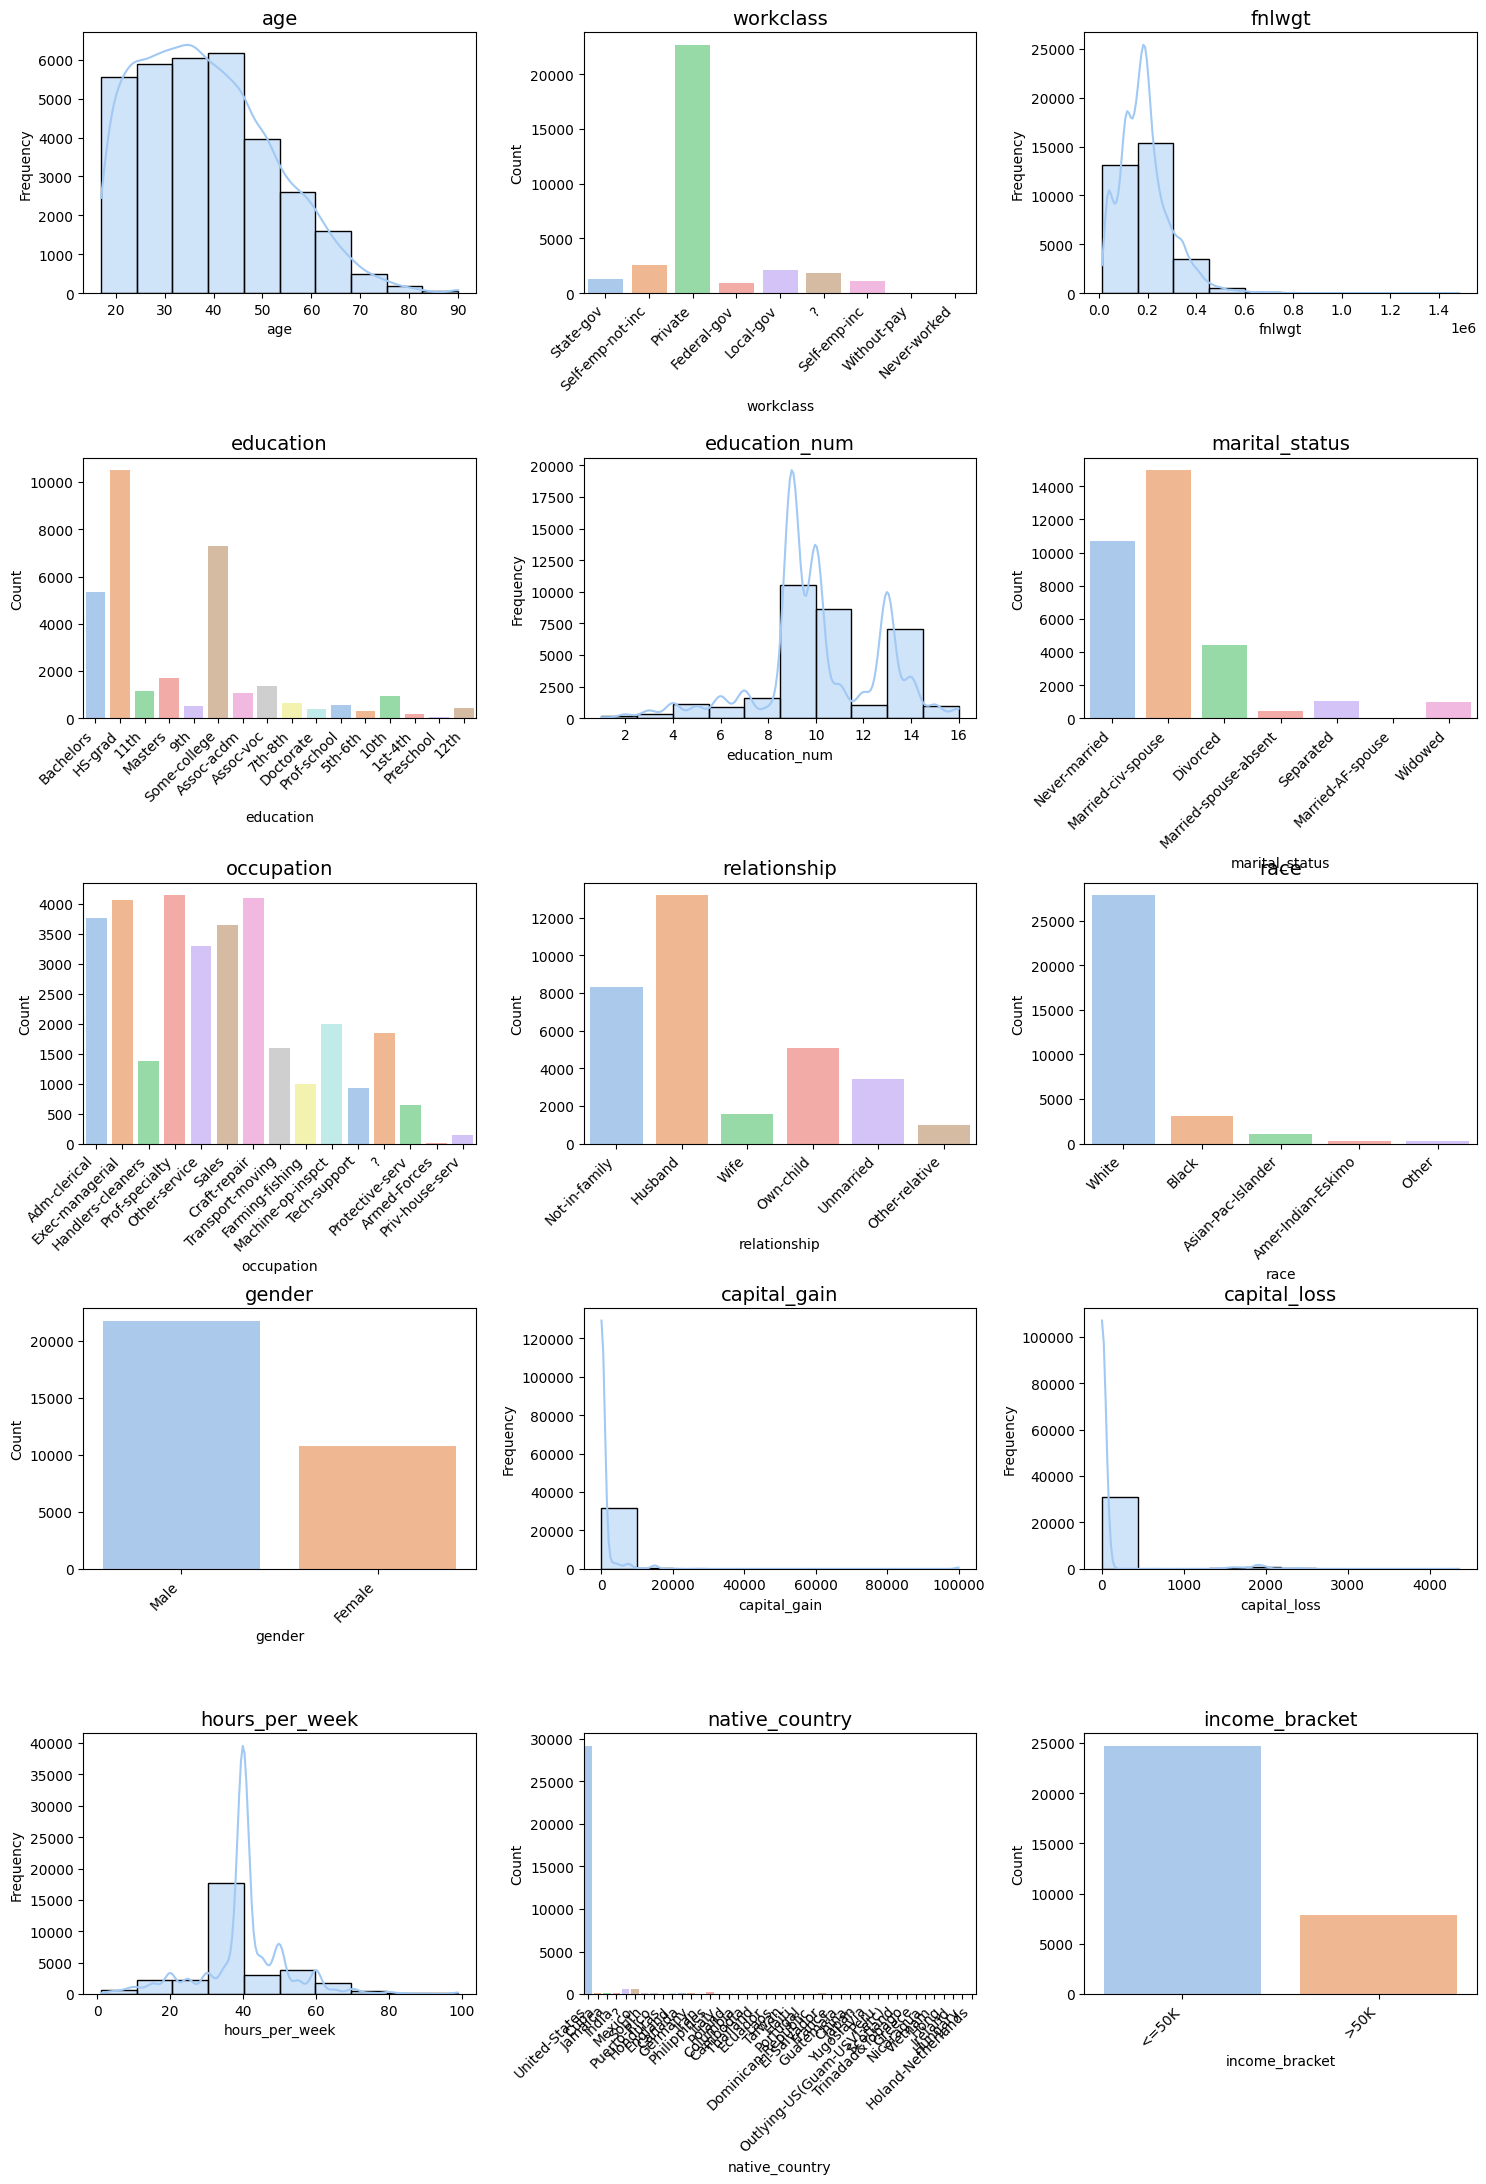

In [10]:
num_cols = 3
num_plots = len(df_train.columns)
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df_train.columns):
    ax = axes[i]
    
    # Vérification du type de données
    if isinstance(df_train[column].dtype, pd.CategoricalDtype) or df_train[column].dtype == object:
        sns.countplot(x=column, hue=column, data=df_train, ax=ax, palette="pastel", legend=False)
        ax.set_ylabel("Count")
    
        ax.set_xticks(range(len(df_train[column].unique())))
        ax.set_xticklabels(df_train[column].unique(), rotation=45, ha='right')

    else:
        # Palette dynamique selon le nombre d'éléments uniques
        unique_vals = df_train[column].nunique()
        color = sns.color_palette("pastel", n_colors=unique_vals)
        
        sns.histplot(df_train[column], kde=True, bins=10, ax=ax, color=color[0])
        ax.set_ylabel("Frequency")
    
    ax.set_title(f"{column}", fontsize=14)

# Supprimer les sous-graphiques inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


##### Clean data

In [11]:
# Set label column
df_train['income_bracket'] = (df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test['income_bracket'] = (df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [12]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# Bias

### Sensitive features

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

We consider the following sensitive features:

* `race`- Risk of racial discrimination in economic decisions.
* `gender` - Pay differentials and gender stereotypes can introduce bias.
* `native_country` - Can be a proxy for socio-economic disparities based on origin.
* `age` - Can lead to discrimination linked to professional seniority or access to economic opportunities.
* `marital_status` - May be correlated with income inequalities based on societal norms.

Among them, gender is binary, age is continuous (requires binning) and the others are categorical


</div>

### Detailed sensitive groups

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Gender**
* Male
* Female

**Age**
* Less than 30 years
* Between 30 and 40
* Between 40 and 50
* Greater than 50

**Race**
* White
* Black
* Asian-Pac-Islander
* Amer-Indian-Eskimo
* Other

**Marital Statut**
* Married
* Widowed
* Divorced
* Separated
* Never married
* Married-civ-spouse
* Married-AF-spouse

</div>

In [13]:
# List of original sensitive features before one-hot-encoding
original_sensitive_features = ['gender', 'race', 'marital_status']

### Preprocess

In [14]:
def preprocess(df):

    # Split the DataFrame into features (x) and target variable (y)
    x = df.copy()
    x.drop('income_bracket', axis=1, inplace=True)
    y = df['income_bracket']

    # Binning the age feature into groups
    x['age_less_than_30'] = x['age'] < 30
    x['age_between_30_and_40'] = (x['age'] >= 30) & (x['age'] < 40)
    x['age_between_40_and_50'] = (x['age'] >= 40) & (x['age'] < 50)
    x['age_greater_than_50'] = x['age'] >= 50
    # Dropping the original 'age' column after binning
    x.drop('age', axis=1, inplace=True)

    return x, y

### Preparing sets

##### Preparing the train set

In [15]:
x_train, y_train = preprocess(df_train)
x_train.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False,True,False,False
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False,False,False,True
2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False,True,False,False
3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False,False,False,True
4,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,True,False,False,False


In [16]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
x_train_encoded = pd.get_dummies(x_train)
x_train_encoded.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,77516,13,2174,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,83311,13,0,0,13,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,215646,9,0,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,234721,7,0,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,338409,13,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Check if no columns are missing.
print([c for c in x_train_encoded.columns if c not in pd.get_dummies(df_train).columns])
print([c for c in pd.get_dummies(df_train).columns if c not in x_train_encoded.columns])

['age_less_than_30', 'age_between_30_and_40', 'age_between_40_and_50', 'age_greater_than_50']
['age', 'income_bracket']


In [18]:
# Scaling dataset
scaler = MinMaxScaler()
x_train_scaled = x_train_encoded.copy()
x_train_scaled[x_train_scaled.columns] = scaler.fit_transform(x_train_scaled[x_train_scaled.columns])
x_train_scaled.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.044302,0.800000,0.02174,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.138113,0.533333,0.00000,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.221488,0.800000,0.00000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Under sampling, to train the model on a balanced train set
sampler = RandomUnderSampler(random_state=5)
subxtrain, subytrain = sampler.fit_resample(x_train_scaled, y_train)
subytrain.value_counts()

income_bracket
0    7841
1    7841
Name: count, dtype: int64

##### Preparing the test set

In [20]:
x_test, y_test = preprocess(df_test)
x_test.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50
0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,True,False,False,False
1,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,False,True,False,False
2,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,True,False,False,False
3,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,False,False,True,False
4,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,True,False,False,False


In [21]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
x_test_encoded = pd.get_dummies(x_test)

# Ensure test set has the same columns as the train set
x_test_encoded = x_test_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)

In [22]:
x_test_encoded.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,226802,7,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,89814,9,0,0,50,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,336951,12,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,160323,10,7688,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,103497,10,0,0,30,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [23]:
# Scaling dataset
scaler = MinMaxScaler()
x_test_scaled = x_test_encoded.copy()
x_test_scaled[x_test_scaled.columns] = scaler.fit_transform(x_test_scaled[x_test_scaled.columns])
x_test_scaled.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.144430,0.400000,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.051677,0.533333,0.000000,0.0,0.500000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.219011,0.733333,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.099418,0.600000,0.076881,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.060942,0.600000,0.000000,0.0,0.295918,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
# Under sampling
sampler = RandomUnderSampler(random_state=5)
subxtest, subytest = sampler.fit_resample(x_test_scaled, y_test)
subytest.value_counts()

income_bracket
0    3846
1    3846
Name: count, dtype: int64

In [25]:
sampler = RandomUnderSampler(random_state=5)
subxtest_bis, subytest_bis = sampler.fit_resample(x_test, y_test)
subytest.value_counts()

income_bracket
0    3846
1    3846
Name: count, dtype: int64

In [26]:
subxtest_bis.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50
15389,Private,305129,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,True,False,False,False
13987,?,358355,12th,8,Never-married,?,Unmarried,White,Female,0,0,35,United-States,True,False,False,False
3277,Private,275446,Some-college,10,Separated,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,United-States,False,False,True,False
3184,Private,77521,11th,7,Never-married,Priv-house-serv,Unmarried,White,Female,0,0,40,United-States,False,False,False,True
2244,Private,297767,Masters,14,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,0,40,United-States,False,True,False,False


In [27]:
subxtest.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
15389,0.197465,0.400000,0.0,0.0,0.448980,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13987,0.233503,0.466667,0.0,0.0,0.346939,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3277,0.177366,0.600000,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3184,0.043353,0.400000,0.0,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2244,0.192480,0.866667,0.0,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Define MLP

In [28]:
# Define the MLP model
mlp = Sequential([
        Input(shape=(subxtrain.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

### Training

In [29]:
# Compilation and training
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(subxtrain, subytrain, epochs=100, batch_size=32, verbose=0)

In [30]:
# Evaluate the model
yhat_train = (mlp.predict(subxtrain) >= 0.5).astype(int).ravel()
print("MLP Training Accuracy on train set :", accuracy_score(subytrain, yhat_train))

491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step
MLP Training Accuracy on train set : 0.8890447646983803


### Classification Performance

In [31]:
yhat = (mlp.predict(subxtest) >= 0.5).astype(int).ravel()
print(classification_report(np.array(subytest), yhat, target_names=['<=50K', '>50K']))

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
              precision    recall  f1-score   support

       <=50K       0.84      0.78      0.81      3846
        >50K       0.80      0.85      0.82      3846

    accuracy                           0.82      7692
   macro avg       0.82      0.82      0.82      7692
weighted avg       0.82      0.82      0.82      7692



### Fairness quantification with Fairlearn

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
The Justicia library was too outdated, causing compatibility issues, which is why we opted to use Fairlearn instead.
</div>

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Fairness metrics help evaluate whether machine learning models treat different demographic groups equitably. 

- **Statistical Parity / Demographic Parity** ensures that the selection rate is the same across different demographic groups, regardless of their actual qualifications. It is useful when aiming for equal access to opportunities.  
- **Equality of Opportunity** ensures that individuals who truly qualify for a positive outcome (e.g., deserving a loan) have the same chance of being correctly classified, regardless of their demographic group. It focuses on fairness for those who deserve the opportunity.  
- **Predictive Value Parity (PVP)** ensures that when a model predicts a positive outcome, the likelihood of that prediction being correct is the same across groups. It is crucial in high-stakes decisions like medical diagnoses or criminal justice to maintain trust in predictions. * 

We consider 4 scenarios with different choices of sensitive features :
* Gender 
* Gender and marital status
* Race
* Race and gender

Statistical Parity can be particularly useful in ensuring that different groups, such as those defined by gender or race, have equal access to the opportunities predicted by the model, regardless of other personal characteristics.
</div>

##### Gender

In [32]:
# We compute P(Ŷ = 1 | Sex) using MetricFrame
gender_cond = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis['gender']
)

In [33]:
# We extract probabilities per group
probas = gender_cond.by_group.to_dict()

groups = list(probas.keys())
values = list(probas.values())

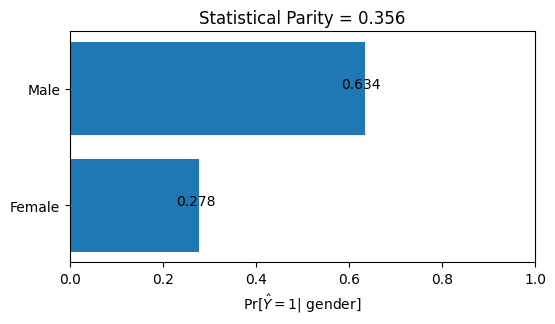

In [34]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis['gender'])
ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ gender]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [35]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis['gender'])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 0.127


##### Gender and marital status

In [36]:
# Compute P(Ŷ = 1 | gender, marital_status)
cond_genmar = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis[['gender', 'marital_status']]
)

In [37]:
# Extract probabilities per (gender, marital_status) group
probas = cond_genmar.by_group.to_dict()
groups = [str(g) for g in probas.keys()]
values = list(probas.values())

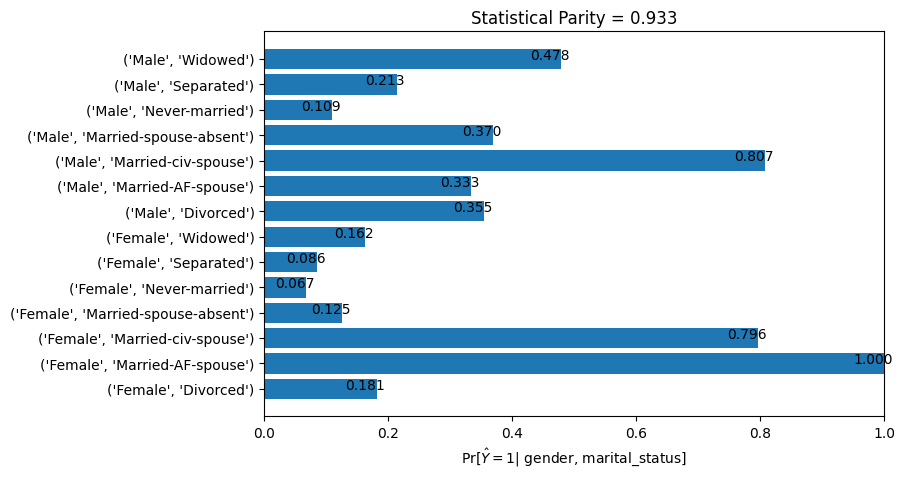

In [38]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

# Compute Statistical Parity Difference for both features
stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis[['gender', 'marital_status']])

ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ gender, marital_status]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [39]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis[['gender', 'marital_status']])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 1.000


##### Race

In [40]:
# Compute P(Ŷ = 1 | gender, marital_status)
cond_race = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis[['race']]
)

In [41]:
# Extract probabilities per (gender, marital_status) group
probas = cond_race.by_group.to_dict()

groups = list(probas.keys())
values = list(probas.values())

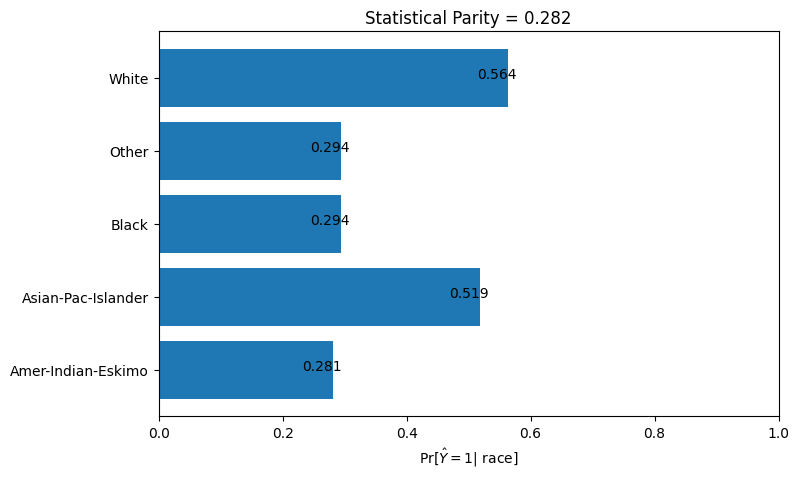

In [42]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

# Compute Statistical Parity Difference for both features
stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis[['race']])

ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ race]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [43]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis['race'])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 0.231


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The SPD suggests that the predicted probability of a positive outcome $(\hat{Y} = 1)$ varies significantly across racial groups. White and Asian-Pac-Islander individuals have the highest probabilities (0.560 and 0.515, respectively), while Amer-Indian-Eskimo (0.234) and Other (0.265) groups have the lowest. This indicates potential bias in the model's predictions, as certain racial groups are favored more than others.

The EOD = 0.387 further highlights the disparity in how the model treats different groups among the actual positive class (i.e., those who receive an income upper than 50k). A high EOD value suggests that the model does not provide equal true positive rates across groups, meaning some groups receive significantly fewer correct positive predictions than others.
</div>

##### Race and gender

In [44]:
# Compute P(Ŷ = 1 | gender, marital_status)
cond_racegen = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis[['race', 'gender']]
)

In [45]:
# Extract probabilities per (gender, marital_status) group
probas = cond_racegen.by_group.to_dict()
groups = [str(g) for g in probas.keys()]
values = list(probas.values())

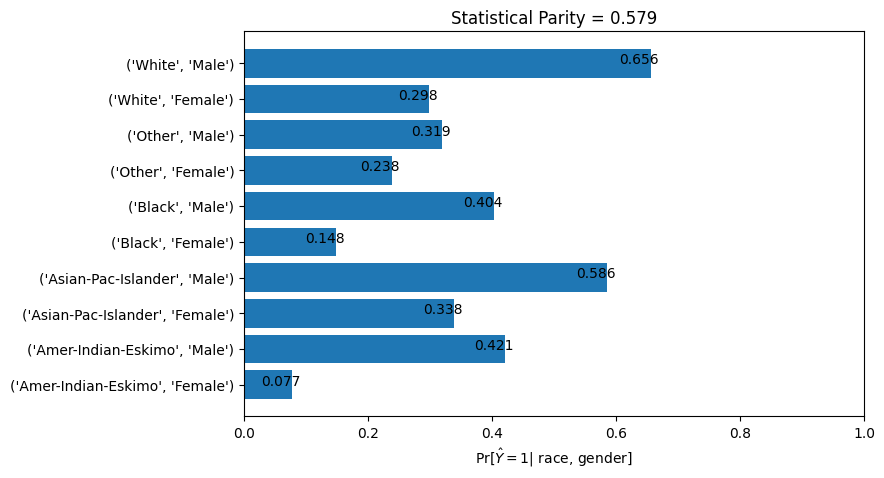

In [46]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

# Compute Statistical Parity Difference for both features
stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis[['race', 'gender']])

ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ race, gender]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [47]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis[['race', 'gender']])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 0.381


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

This bar chart provides a more granular view of statistical parity by considering both race and gender. The SPD = 0.538 indicates a significant disparity in the likelihood of receiving a positive outcome $(\hat{Y} = 1)$ across demographic groups.
* White Males (0.654) and Asian-Pac-Islander Males (0.580) have the highest probabilities of receiving an income upper than 50k.
* Black Females (0.145) and Amer-Indian-Eskimo Females (0.115) have the lowest, meaning they are significantly disadvantaged in the model’s predictions.
* Across all racial groups, females tend to have lower probabilities than their male counterparts, indicating gender-based disparities in addition to racial disparities.

The EOD = 0.562 highlights that even among those who truly deserve a positive outcome, the model treats groups unequally.
</div>

## Improving fairness by a pre-processing fairness algorithm

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
The combination of high SPD and high EOD suggests both allocative harm (certain groups get upper income) and representational harm (the model favors some groups over others even among truly deserving individuals).

To mitigate this unfairness, pre-processing techniques (e.g., reweighing, disparate impact removal), in-processing fairness-aware training (e.g., adversarial debiasing), or post-processing corrections (e.g., equalized odds adjustments) could be applied.
</div>

In [ ]:
encoded_df_train = subxtrain.copy()
encoded_df_train['target'] = subytrain

encoded_df_test = subxtest.copy()
encoded_df_test['target'] = subytest


binary_label_dataset_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_train,
    label_names=['target'],
    protected_attribute_names=['gender_Female'])
binary_label_dataset_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_test,
    label_names=['target'],
    protected_attribute_names=['gender_Female'])

In [63]:
# Reweighing algorithm
rw = Reweighing(unprivileged_groups=[{'gender_Female' : 1}], privileged_groups=[{'gender_Female' : 0}])
rw.fit(binary_label_dataset_train)

binary_label_dataset_trans_train = rw.transform(binary_label_dataset_train)
dataset_transf_train = binary_label_dataset_trans_train.convert_to_dataframe()[0]
dataset_transf_test = rw.transform(binary_label_dataset_test).convert_to_dataframe()[0]

X_trans_train = dataset_transf_train.drop(['target'], axis = 1)
y_trans_train = dataset_transf_train['target']

X_trans_test = dataset_transf_test.drop(['target'], axis = 1)
y_trans_test = dataset_transf_test['target']

##### Retraining after fairness repair

In [64]:
# Define the MLP model
mlp_trans = Sequential([
        Input(shape=(X_trans_train.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [65]:
# Compilation and training
mlp_trans.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp_trans.fit(X_trans_train, y_trans_train, epochs=100, batch_size=32, verbose=0, sample_weight= binary_label_dataset_trans_train.instance_weights)

In [66]:
# Evaluate the model
yhat_train_trans = (mlp_trans.predict(X_trans_train) >= 0.5).astype(int).ravel()
print("MLP Training Accuracy on train set :", accuracy_score(y_trans_train, yhat_train_trans))

491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
MLP Training Accuracy on train set : 0.8804999362326233


##### Classification Performance

In [67]:
yhat_trans = (mlp_trans.predict(X_trans_test) >= 0.5).astype(int).ravel()
print(classification_report(np.array(y_trans_test), yhat_trans, target_names=['<=50K', '>50K']))

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

       <=50K       0.81      0.81      0.81      3846
        >50K       0.81      0.81      0.81      3846

    accuracy                           0.81      7692
   macro avg       0.81      0.81      0.81      7692
weighted avg       0.81      0.81      0.81      7692



##### Compare the difference in statistical parity with respect to gender

Statistical Parity Before:  0.356
Statistical Parity After:  0.243


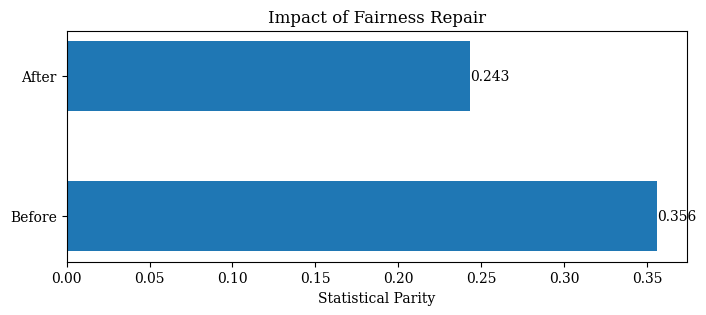

<Figure size 800x300 with 0 Axes>

In [68]:
statistical_parity_before = round(demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis['gender']), 3)
statistical_parity_after = round(demographic_parity_difference(y_true=y_trans_test, y_pred=yhat_trans, sensitive_features=X_trans_test['gender_Female']), 3)

print("Statistical Parity Before: ", statistical_parity_before)
print("Statistical Parity After: ", statistical_parity_after)

# bar plot of statistical parity before and after
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.figsize'] = (8, 3)
fig, ax = plt.subplots()
bars = ax.barh(['Before', 'After'], [statistical_parity_before, statistical_parity_after], 0.5)
ax.bar_label(bars)
plt.xlabel("Statistical Parity")
plt.title("Impact of Fairness Repair")
plt.show()
plt.clf()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The approach used relies on pre-processing with the Reweighing algorithm, which adjusts sample weights to reduce gender bias before training the model. This method enhances fairness without modifying the model’s architecture or learning process. The analysis of SPD before and after correction shows a reduction in unfairness, making predictions more equitable between protected and non-protected groups.

However, this adjustment may lead to a drop in accuracy, highlighting the trade-off between fairness and performance. Additionally, Reweighing primarily improves Statistical Parity but does not directly address Equality of Opportunity, meaning disparities in true positive rates may still persist. Another limitation is its effectiveness in cases of severe dataset imbalance—if one group is underrepresented, simply reweighting samples may not provide sufficient corrective power.

While Reweighing is a simple and broadly applicable solution, it does not address all structural biases in the data, especially those arising from complex feature dependencies. Therefore, combining it with other approaches, such as in-processing (e.g., adversarial debiasing) or post-processing (e.g., Equalized Odds adjustments), may be necessary to achieve a model that is both fair and performant.
</div>

## Explaining the sources of unfairness

In [86]:
fairXplainer = FairXplainer(mlp, subxtest, ['gender_Female'])


In [89]:
# Assure-toi de spécifier tous les paramètres nécessaires
explanations = fairXplainer.compute(
    maxorder=2, 
    spline_intervals=3, 
    verbose=True, 
    cpu_time=2000, 
    compute_sp_only=True  # Tu peux essayer de ne pas limiter à SP seulement
)


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [69]:
# Vérifier si 'gender_Female' est bien dans subxtest
print('gender_Female' in subxtest.columns)

# Vérifie le nombre de valeurs uniques dans la colonne pour s'assurer qu'elle est correctement encodée
print(subxtest['gender_Female'].value_counts())


True
gender_Female
0.0    5594
1.0    2098
Name: count, dtype: int64


In [55]:
# Set the start method to 'spawn' for Windows
multiprocessing.set_start_method('spawn', force=True)

# Your existing code
fairXplainer = FairXplainer(mlp, subxtest, ['gender_Female'])
fairXplainer.compute(maxorder=2, spline_intervals=3, verbose=False, cpu_time=2000, compute_sp_only=True)


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


In [56]:
print(fairXplainer.result.head())

Empty DataFrame
Columns: []
Index: []


##### Gender

In [57]:
subxtest = subxtest.reset_index(drop=True)
subxtest

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.197465,0.400000,0.000000,0.000000,0.448980,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.233503,0.466667,0.000000,0.000000,0.346939,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.177366,0.600000,0.000000,0.000000,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.043353,0.400000,0.000000,0.000000,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.192480,0.866667,0.000000,0.000000,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,0.091986,0.866667,0.000000,0.000000,0.500000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7688,0.006544,0.866667,0.000000,0.504509,0.500000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7689,0.127751,0.933333,0.150242,0.000000,0.551020,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7690,0.085215,0.866667,0.000000,0.000000,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
from multiprocessing import get_context
num_processes = 8
pool = get_context("spawn").Pool(num_processes)
pool.close()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/76 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 842us/step


  1%|▏         | 1/76 [00:06<08:13,  6.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 792us/step


  3%|▎         | 2/76 [00:12<07:28,  6.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 697us/step


  4%|▍         | 3/76 [00:17<06:51,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 738us/step


  5%|▌         | 4/76 [00:23<06:46,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 816us/step


  7%|▋         | 5/76 [00:29<06:57,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 845us/step


  8%|▊         | 6/76 [00:35<07:04,  6.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 906us/step


  9%|▉         | 7/76 [00:44<08:04,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 810us/step


 11%|█         | 8/76 [00:50<07:35,  6.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 753us/step


 12%|█▏        | 9/76 [00:56<07:07,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 782us/step


 13%|█▎        | 10/76 [01:02<06:49,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 727us/step


 14%|█▍        | 11/76 [01:07<06:29,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 793us/step


 16%|█▌        | 12/76 [01:13<06:25,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 764us/step


 17%|█▋        | 13/76 [01:19<06:16,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 858us/step


 18%|█▊        | 14/76 [01:26<06:17,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 803us/step


 20%|█▉        | 15/76 [01:32<06:08,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 774us/step


 21%|██        | 16/76 [01:37<05:56,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 728us/step


 22%|██▏       | 17/76 [01:43<05:43,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 909us/step


 24%|██▎       | 18/76 [01:50<05:53,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 818us/step


 25%|██▌       | 19/76 [01:56<05:57,  6.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 964us/step


 26%|██▋       | 20/76 [02:04<06:08,  6.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


 28%|██▊       | 21/76 [02:12<06:30,  7.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 974us/step


 29%|██▉       | 22/76 [02:19<06:18,  7.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


 30%|███       | 23/76 [02:26<06:21,  7.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 891us/step


 32%|███▏      | 24/76 [02:33<06:02,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


 33%|███▎      | 25/76 [02:41<06:13,  7.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 34%|███▍      | 26/76 [02:48<06:05,  7.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 938us/step


 36%|███▌      | 27/76 [02:55<05:49,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 777us/step


 37%|███▋      | 28/76 [03:01<05:30,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 801us/step


 38%|███▊      | 29/76 [03:07<05:10,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 943us/step


 39%|███▉      | 30/76 [03:14<05:08,  6.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 915us/step


 41%|████      | 31/76 [03:21<05:03,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 842us/step


 42%|████▏     | 32/76 [03:27<04:50,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 931us/step


 43%|████▎     | 33/76 [03:34<04:42,  6.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 826us/step


 45%|████▍     | 34/76 [03:40<04:31,  6.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 869us/step


 46%|████▌     | 35/76 [03:46<04:23,  6.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 824us/step


 47%|████▋     | 36/76 [03:52<04:11,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


 49%|████▊     | 37/76 [04:00<04:24,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 916us/step


 50%|█████     | 38/76 [04:07<04:14,  6.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 822us/step


 51%|█████▏    | 39/76 [04:13<04:00,  6.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 854us/step


 53%|█████▎    | 40/76 [04:19<03:50,  6.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 927us/step


 54%|█████▍    | 41/76 [04:26<03:46,  6.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 823us/step


 55%|█████▌    | 42/76 [04:32<03:35,  6.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 800us/step


 57%|█████▋    | 43/76 [04:38<03:26,  6.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 967us/step


 58%|█████▊    | 44/76 [04:45<03:28,  6.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 936us/step


 59%|█████▉    | 45/76 [04:52<03:26,  6.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 61%|██████    | 46/76 [05:01<03:45,  7.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 62%|██████▏   | 47/76 [05:09<03:39,  7.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 63%|██████▎   | 48/76 [05:16<03:31,  7.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 891us/step


 64%|██████▍   | 49/76 [05:23<03:14,  7.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 838us/step


 66%|██████▌   | 50/76 [05:29<03:00,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 912us/step


 67%|██████▋   | 51/76 [05:36<02:52,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 784us/step


 68%|██████▊   | 52/76 [05:42<02:37,  6.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 926us/step


 70%|██████▉   | 53/76 [05:48<02:32,  6.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 71%|███████   | 54/76 [05:56<02:29,  6.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 819us/step


 72%|███████▏  | 55/76 [06:02<02:18,  6.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 858us/step


 74%|███████▎  | 56/76 [06:09<02:12,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 830us/step


 75%|███████▌  | 57/76 [06:15<02:06,  6.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


 76%|███████▋  | 58/76 [06:24<02:08,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 835us/step


 78%|███████▊  | 59/76 [06:29<01:54,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 804us/step


 79%|███████▉  | 60/76 [06:35<01:43,  6.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 834us/step


 80%|████████  | 61/76 [06:41<01:35,  6.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 887us/step


 82%|████████▏ | 62/76 [06:48<01:31,  6.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 83%|████████▎ | 63/76 [06:55<01:27,  6.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 843us/step


 84%|████████▍ | 64/76 [07:01<01:18,  6.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 980us/step


 86%|████████▌ | 65/76 [07:08<01:12,  6.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 881us/step


 87%|████████▋ | 66/76 [07:15<01:07,  6.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 88%|████████▊ | 67/76 [07:22<01:01,  6.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 780us/step


 89%|████████▉ | 68/76 [07:28<00:51,  6.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 677us/step


 91%|█████████ | 69/76 [07:33<00:42,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 772us/step


 92%|█████████▏| 70/76 [07:39<00:35,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 941us/step


 93%|█████████▎| 71/76 [07:45<00:30,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 95%|█████████▍| 72/76 [07:52<00:25,  6.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 96%|█████████▌| 73/76 [07:59<00:19,  6.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 851us/step


 97%|█████████▋| 74/76 [08:06<00:13,  6.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 788us/step


 99%|█████████▊| 75/76 [08:12<00:06,  6.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5173/5173 ━━━━━━━━━━━━━━━━━━━━ 4s 813us/step


100%|██████████| 76/76 [08:18<00:00,  6.56s/it]


<Figure size 800x300 with 0 Axes>

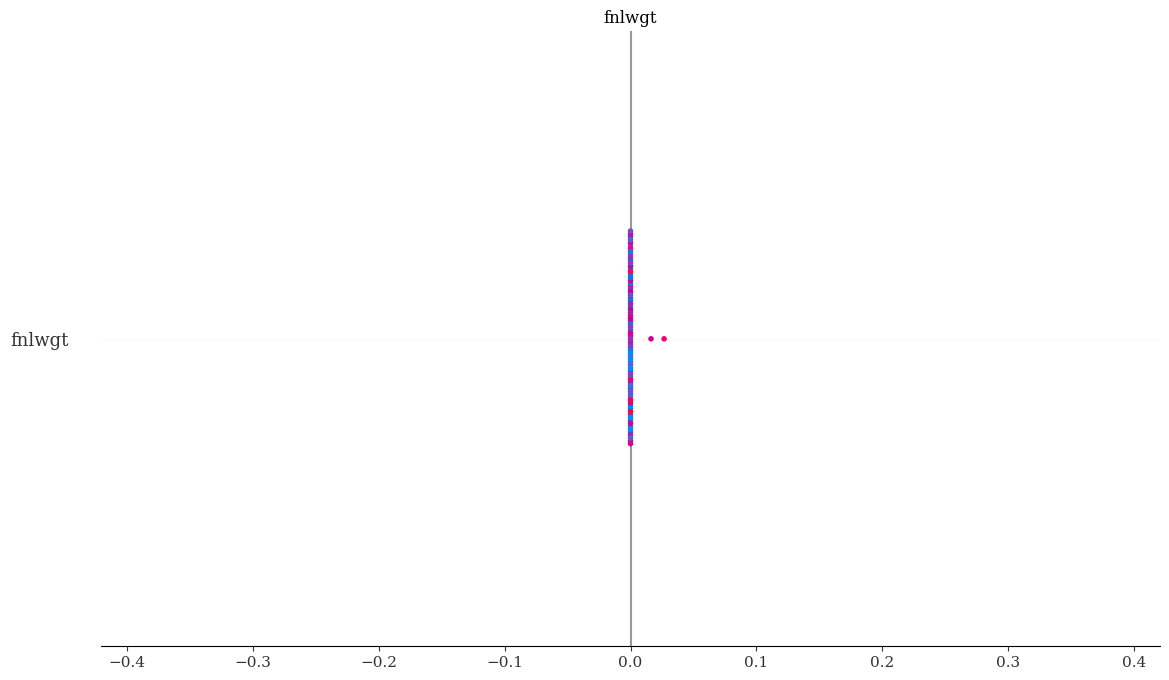

In [102]:
from sklearn.model_selection import train_test_split
import shap

# Créer un sous-ensemble stratifié de 100 échantillons
X_sample, _, y_sample, _ = train_test_split(
    subxtest,  # données d'entrée
    subytest,  # labels
    test_size=0.990,  # Réduit à 100 échantillons (1 - 100/7692 = 0.998)
    stratify=subytest,  # Maintient l'équilibre des classes
    random_state=42
)

# Créer l'explainer SHAP en utilisant ce sous-ensemble réduit
explainer = shap.KernelExplainer(mlp.predict, X_sample)

# Calculer les valeurs SHAP pour l'échantillon réduit
shap_values = explainer.shap_values(X_sample)

# Afficher les résultats
shap.summary_plot(shap_values, X_sample)


In [ ]:
import multiprocessing

if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)
    # Initialisation de FairXplainer
    fx = FairXplainer(mlp, subxtest, ['gender_Female'])

    # Calcul des explications
    fx_explanations = fx.compute(verbose=True)


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step



c Decomposition for  gender_Female = 0.0
c positive prediction probability of  gender_Female = 0.0 is 0.5544617
c sample shape: (5594, 111)
c sensitive group: gender_Female = 0.0
c variance of Y 0.14105248
c mean of Y 0.5544617


ValueError: cannot find context for 'fork'

In [ ]:
from fairxplainer.wrapper.shap_fairness_explanation import ShapExplanation, row_masking_based_on_sensitive_groups
max_group_mask, min_group_mask = row_masking_based_on_sensitive_groups(mlp, subxtest, ['gender_Female'])
shapExplanation = ShapExplanation()
result_shap, exact_SP = shapExplanation.compute(mlp, subxtest, max_group_mask, min_group_mask, "mlp", verbose=False)

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


ValueError: cannot find context for 'fork'

In [ ]:
subxtest_df = subxtest.iloc[:, :-1] 
# Initialisation de FairXplainer
fx = FairXplainer(mlp, x_test_scaled, ['gender_Female'])


In [ ]:
# Calcul des explications
fx_explanations = fx.compute(maxorder=2, spline_intervals=6, verbose=True, approach="kernel")

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  



c Decomposition for  gender_Female = 0.0
c positive prediction probability of  gender_Female = 0.0 is 0.42678893


InvalidIndexError: (slice(None, None, None), [0])

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Crée l'explainer
explainer = LimeTabularExplainer(subxtrain.values, training_labels=subytrain, mode='classification')

# Expliquer la prédiction pour cet échantillon
explanation = explainer.explain_instance(subxtest, mlp, num_features=10)

# Affiche l'explication
explanation.show_in_notebook()


InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
# Vérifie la forme de sample_input avant de le passer au modèle
sample_input = subxtest.iloc  # Sélectionne une ligne sans la cible
sample_input = sample_input.values.reshape(1, -1)  # Redimensionne pour avoir la forme (1, 110)
print(f"Shape of sample_input: {sample_input.shape}")  # Vérifie la forme
prediction = mlp.predict(sample_input)
print(prediction)

AttributeError: '_iLocIndexer' object has no attribute 'values'

In [ ]:
k = 10
fairXplainer_result = fx.get_weights()
plt = fif_plot(fairXplainer_result,
               draw_waterfall=True,
               figure_size=(9,5),
               text_y_pad=0.2,
               xlim=None,
               result_x_pad=0.02,
               x_label="Influence on Statistical Parity"
        )
plt.tight_layout()
plt.show()
plt.clf()

KeyError: 'VarTotal'

In [ ]:
help(FairXplainer)

Help on class FairXplainer in module fairxplainer.fair_explainer:

class FairXplainer(builtins.object)
 |  FairXplainer(classifier, dataset, sensitive_features, label=None, verbose=False)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, classifier, dataset, sensitive_features, label=None, verbose=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  compute(self, maxorder=2, lambax=0.01, spline_intervals=2, explain_sufficiency_fairness=False, approach='hdmr', compute_sp_only=False, verbose=False, seed=22, cpu_time=300)
 |      This code computes the variance of individual and intersectional features, the sum of which 
 |      equals the overall variance of the prediction of the classifier. 
 |      Variance computation is grouped by each sensitive group
 |  
 |  get_top_k_weights(self, k=None)
 |      Returns the top k weights of the features. This is called after compute() is called.
 |  
 |  get_weights(self)
 |      Returns the weights of the f

In [ ]:
help(FairXplainer.compute)

Help on function compute in module fairxplainer.fair_explainer:

compute(self, maxorder=2, lambax=0.01, spline_intervals=2, explain_sufficiency_fairness=False, approach='hdmr', compute_sp_only=False, verbose=False, seed=22, cpu_time=300)
    This code computes the variance of individual and intersectional features, the sum of which 
    equals the overall variance of the prediction of the classifier. 
    Variance computation is grouped by each sensitive group



In [ ]:
fairXplainer_result = fairXplainer.get_weights()
# Affichage des résultats
print(fairXplainer_result)

KeyError: 'VarTotal'

In [ ]:
k = 10
fairXplainer_result = fairXplainer.get_weights()
plt = fif_plot(fairXplainer_result,
               draw_waterfall=True,
               figure_size=(9,5),
               text_y_pad=0.2,
               xlim=None,
               result_x_pad=0.02,
               x_label="Influence on Statistical Parity"
        )
plt.tight_layout()
plt.show()
plt.clf()
# print("Exact statistical parity", fairXplainer.statistical_parity_sample())

KeyError: 'VarTotal'

In [ ]:
help(fairXplainer.get_weights)


Help on method get_weights in module fairxplainer.fair_explainer:

get_weights() method of fairxplainer.fair_explainer.FairXplainer instance
    Returns the weights of the features. This is called after compute() is called.
    Only shows first order influences. Second and higher order influences are summed up.

